In [563]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
import time
from sklearn.cluster import KMeans


from sklearn.metrics import silhouette_score


%matplotlib inline

n_samples = 1500
random_state = 170
transformation = [[1,-1],[-1,2]]


x,y = make_blobs(n_samples=n_samples, random_state=random_state)
xani = np.dot(x, transformation)


In [553]:
x

array([[-5.19811282e+00,  6.41869316e-01],
       [-5.75229538e+00,  4.18627111e-01],
       [-1.08448984e+01, -7.55352273e+00],
       ...,
       [ 1.36105255e+00, -9.07491863e-01],
       [-3.54141108e-01,  7.12241630e-01],
       [ 1.88577252e+00,  1.41185693e-03]])

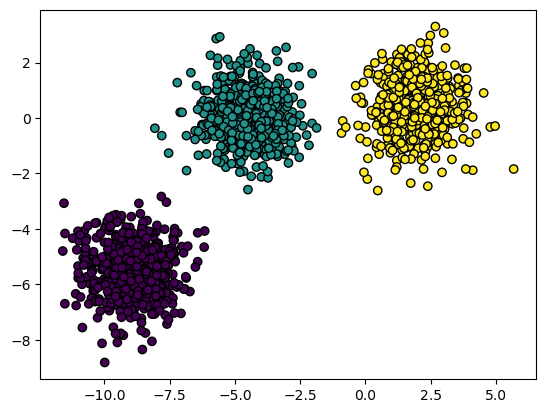

In [555]:
plt.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis', edgecolors='k')

In [501]:
y

array([1, 1, 0, ..., 2, 2, 2])

In [503]:
xani[0:5,0:5]

array([[-5.83998214,  6.48185145],
       [-6.17092249,  6.5895496 ],
       [-3.29137565, -4.26214708],
       [-3.76996743,  2.96895002],
       [-3.55850705,  3.59785195]])

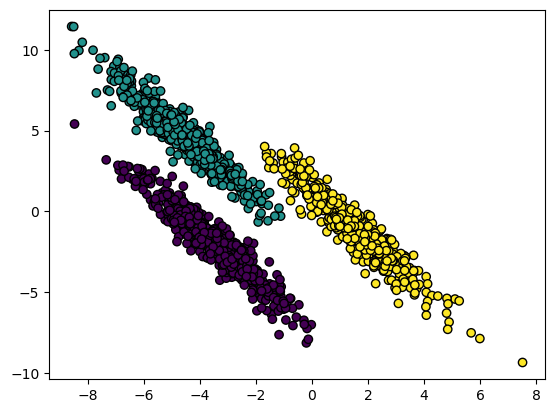

In [505]:
plt.scatter(xani[:, 0], xani[:, 1], c=y, cmap='viridis', edgecolors='k')

J = $\sum^{N}_{n=1}\sum^{K}_{k=1}r(nk)|| x_n - Uk||^2_2$

# K is the number of class
# r(nk) shows if xn is in class k.

In [507]:
def dists(x,cs):
    return np.linalg.norm(x[:,np.newaxis,:]-cs,axis=2)
    
def init(x,k):
    idx=np.random.choice(x.shape[0],k,replace=False)
    return x[idx]

def new_cents(x, labels, k):
    return np.array([x[labels==i].mean(axis=0) if np.any(labels==i)
                     else x[np.random.choice(x.shape[0])] for i in range(k)])

def wcss(x, labels, centroids):
    return sum(np.sum((x[labels == i] - centroids[i])**2) for i in range(len(centroids)))

def kmeans(x, k, max_iters=300, tol=1e-4):
    cents = init(x, k)
    objective_values = []
    
    for _ in range(max_iters):
        ds = dists(x, cents)
        labels = np.argmin(ds, axis=1)
        new_cs = new_cents(x, labels, k)
        
        objective_value = np.sum(np.min(ds, axis=1) ** 2)
        objective_values.append(objective_value)
        
        if np.linalg.norm(new_cs - cents) < tol:
            break
        cents = new_cs
    
    return labels, cents, objective_values


def plot_clusters(x,labels,cents,title):
    plt.scatter(x[:,0],x[:,1],c=labels)
    plt.scatter(cents[:,0],cents[:,1], c='red', marker='x',s=200)
    plt.title(title)
    plt.show()




In [509]:
start_time=time.time()
ls_iso,cents_iso,obj_vals_iso=kmeans(x, 3)
ls_ani,cents_ani,obj_vals_ani=kmeans(xani, 3)
end_time = time.time()
kmeans_t=end_time - start_time

In [511]:
start_time = time.time()
sk_kmeans_iso=KMeans(n_clusters=3, random_state=42, n_init=10).fit(x)
sk_kmeans_ani=KMeans(n_clusters=3, random_state=42, n_init=10).fit(xani)
end_time = time.time()
sklearn_t=end_time - start_time

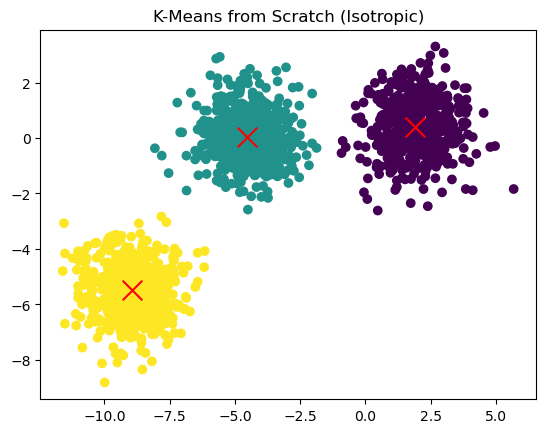

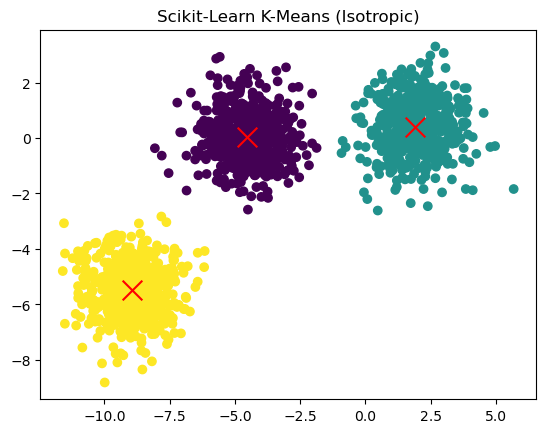

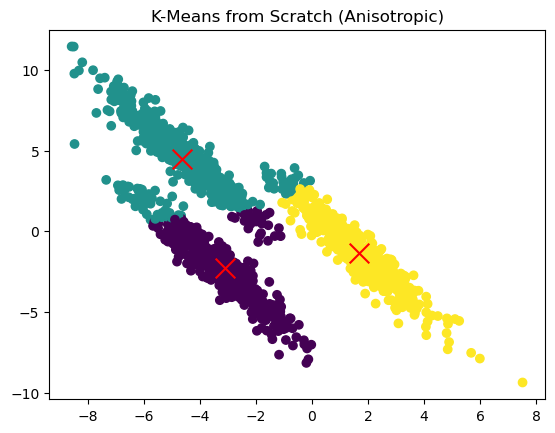

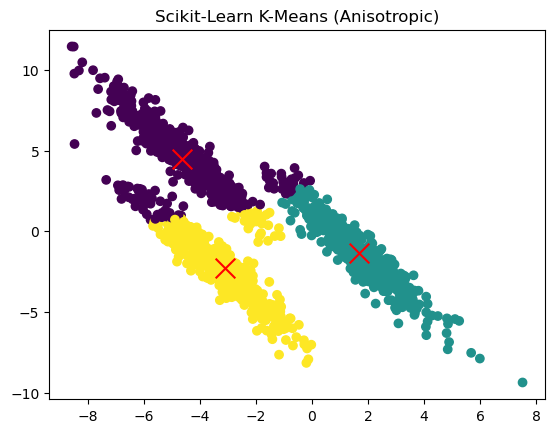

In [513]:
plot_clusters(x,ls_iso,cents_iso, "K-Means from Scratch (Isotropic)")
plot_clusters(x, sk_kmeans_iso.labels_, sk_kmeans_iso.cluster_centers_, "Scikit-Learn K-Means (Isotropic)")
plot_clusters(xani,ls_ani,cents_ani, "K-Means from Scratch (Anisotropic)")
plot_clusters(xani, sk_kmeans_ani.labels_, sk_kmeans_ani.cluster_centers_, "Scikit-Learn K-Means (Anisotropic)")

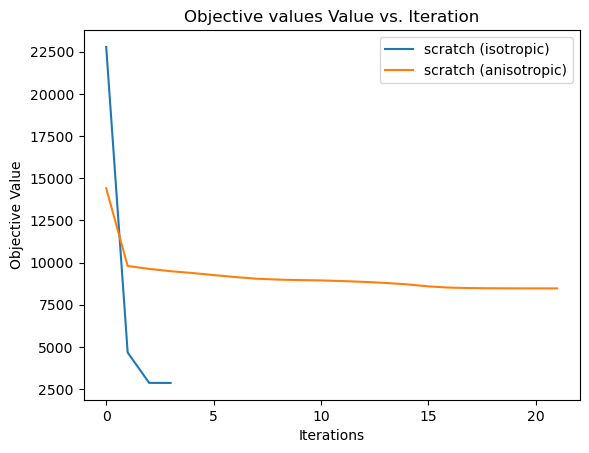

In [515]:
plt.plot(obj_vals_iso, label='scratch (isotropic)')
plt.plot(obj_vals_ani, label='scratch (anisotropic)')
plt.title("Objective values Value vs. Iteration")
plt.xlabel("Iterations")
plt.ylabel("Objective Value")
plt.legend()
plt.show()

In [447]:
print(f"execution time: k means from scratch = {kmeans_t:.4f}s, sklearn = {sklearn_t:.4f}s")

execution time: k means from scratch = 0.0141s, sklearn = 0.0908s


In [449]:
print("final objective value")
print(f"scratch isotropic: {obj_vals_iso[-1]:.4f}")
print(f"scikit-learn isotropic: {sk_kmeans_iso.inertia_:.4f}")
print(f"scratch anisotropic: {obj_vals_ani[-1]:.4f}")
print(f"scikit-learn anisotropic: {sk_kmeans_ani.inertia_:.4f}")

final objective value
scratch isotropic: 2862.7319
scikit-learn isotropic: 2862.7319
scratch anisotropic: 8467.6991
scikit-learn anisotropic: 8467.6991


In [557]:
def kmeans_plus_plus(x, k):
    n_samples, _ = x.shape
    centroids = []
    
    centroids.append(x[np.random.choice(n_samples)])
    
    for _ in range(1, k):
        distances = np.min(cdist(x, np.array(centroids)), axis=1)
        probabilities = distances ** 2
        probabilities /= probabilities.sum()  # Normalize probabilities
        
        next_centroid = x[np.random.choice(n_samples, p=probabilities)]
        centroids.append(next_centroid)
    
    return np.array(centroids)

def percentile_based_init(x, k):
    percentiles = np.linspace(100 / (k + 1), 100 * k / (k + 1), k - 1)
    grid = []
    
    for p1 in percentiles:
        x_percentile = np.percentile(x[:, 0], p1)
        for p2 in percentiles:
            y_percentile = np.percentile(x[:, 1], p2)
            grid.append((x_percentile, y_percentile))
    
    grid = np.array(grid)
    sigma = np.mean(cdist(x, x))
    densities = np.array([np.sum(np.exp(-np.sum((X - g) ** 2, axis=1) / (2 * sigma ** 2))) for g in grid])
    
    top_indices = np.argsort(densities)[-k:]
    return grid[top_indices]

def generate_synthetic_data():
    np.random.seed(42)
    cluster1 = np.random.randn(50, 2) + np.array([2, 2])
    cluster2 = np.random.randn(50, 2) + np.array([-2, -2])
    cluster3 = np.random.randn(50, 2) + np.array([5, -3])
    return np.vstack((cluster1, cluster2, cluster3))


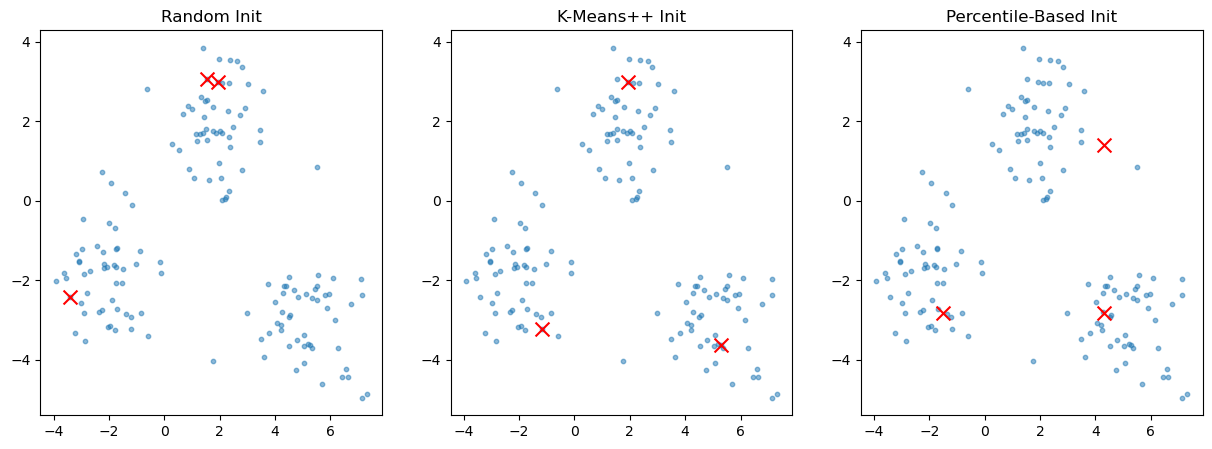

In [559]:

x = generate_synthetic_data()
k = 3

random_init = x[np.random.choice(x.shape[0], k, replace=False)]
kmeanspp_init = kmeans_plus_plus(x, k)
percentile_init = percentile_based_init(x, k)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax, centroids, title in zip(axs, [random_init, kmeanspp_init, percentile_init],
                                ['Random Init', 'K-Means++ Init', 'Percentile-Based Init']):
    ax.scatter(x[:, 0], x[:, 1], s=10, alpha=0.5)
    ax.scatter(centroids[:, 0], centroids[:, 1], marker='x', c='red', s=100)
    ax.set_title(title)
plt.show()


In [585]:
def kmeans_l1(x, k, max_iters=100, tol=1e-4):
    centroids = x[np.random.choice(x.shape[0], k, replace=False)]
    objective_values = []
    for _ in range(max_iters):
        distances = np.sum(np.abs(x[:, np.newaxis, :] - centroids), axis=2)
        labels = np.argmin(distances, axis=1)  # Ensure labels are the correct shape
        
        new_centroids = np.array([
            np.median(x[labels == i], axis=0) if np.any(labels == i) else x[np.random.choice(x.shape[0])]
            for i in range(k)
        ])
        objective_value = np.sum(np.min(distances, axis=1) ** 2)
        objective_values.append(objective_value)
        if np.all(np.abs(new_centroids - centroids) < tol):
            break
        centroids = new_centroids
        
    return labels, centroids,objective_values



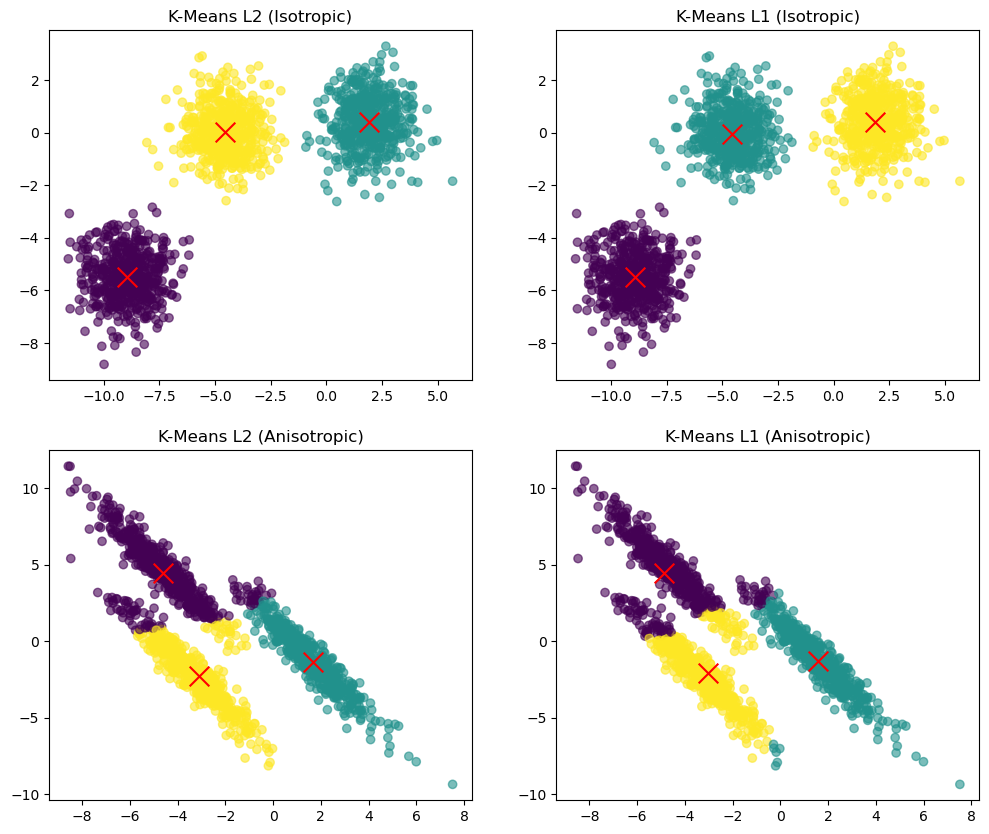

In [595]:
labels_l1_iso, cents_l1_iso,obj_vals_iso1= kmeans_l1(x, k=3)
labels_l1_ani, cents_l1_ani,obj_vals_ani1= kmeans_l1(xani, k=3)


labels_l2_iso, cents_l2_iso, _ = kmeans(x, k=3)
labels_l2_ani, cents_l2_ani, _ = kmeans(xani, k=3)


fig, ax = plt.subplots(2, 2, figsize=(12, 10))


ax[0, 0].scatter(x[:, 0], x[:, 1], c=labels_l2_iso, cmap='viridis', alpha=0.6)
ax[0, 0].scatter(cents_l2_iso[:, 0], cents_l2_iso[:, 1], c='red', marker='x', s=200)
ax[0, 0].set_title("K-Means L2 (Isotropic)")


ax[0, 1].scatter(x[:, 0], x[:, 1], c=labels_l1_iso, cmap='viridis', alpha=0.6)
ax[0, 1].scatter(cents_l1_iso[:, 0], cents_l1_iso[:, 1], c='red', marker='x', s=200)
ax[0, 1].set_title("K-Means L1 (Isotropic)")


ax[1, 0].scatter(xani[:, 0], xani[:, 1], c=labels_l2_ani, cmap='viridis', alpha=0.6)
ax[1, 0].scatter(cents_l2_ani[:, 0], cents_l2_ani[:, 1], c='red', marker='x', s=200)
ax[1, 0].set_title("K-Means L2 (Anisotropic)")


ax[1, 1].scatter(xani[:, 0], xani[:, 1], c=labels_l1_ani, cmap='viridis', alpha=0.6)
ax[1, 1].scatter(cents_l1_ani[:, 0], cents_l1_ani[:, 1], c='red', marker='x', s=200)
ax[1, 1].set_title("K-Means L1 (Anisotropic)")

plt.show()


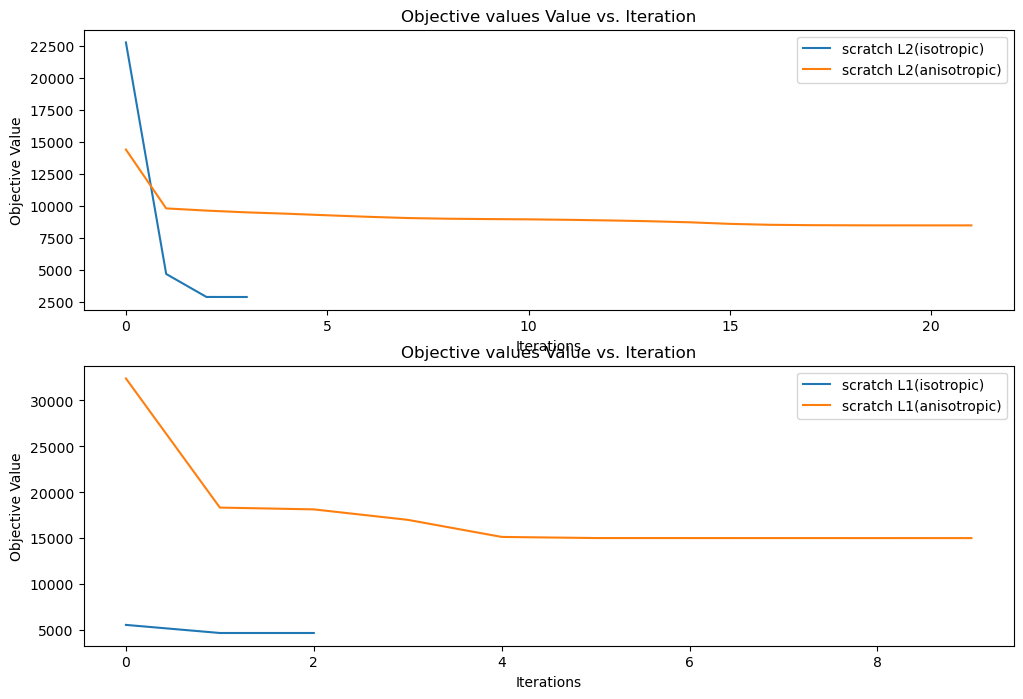

In [599]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

axes[0].plot(obj_vals_iso, label='scratch L2(isotropic)')
axes[0].plot(obj_vals_ani, label='scratch L2(anisotropic)')
axes[0].set_title("Objective values Value vs. Iteration")
axes[0].set_xlabel("Iterations")
axes[0].set_ylabel("Objective Value")
axes[0].legend()

axes[1].plot(obj_vals_iso1, label='scratch L1(isotropic)')
axes[1].plot(obj_vals_ani1, label='scratch L1(anisotropic)')
axes[1].set_title("Objective values Value vs. Iteration")
axes[1].set_xlabel("Iterations")
axes[1].set_ylabel("Objective Value")
axes[1].legend()
plt.show()

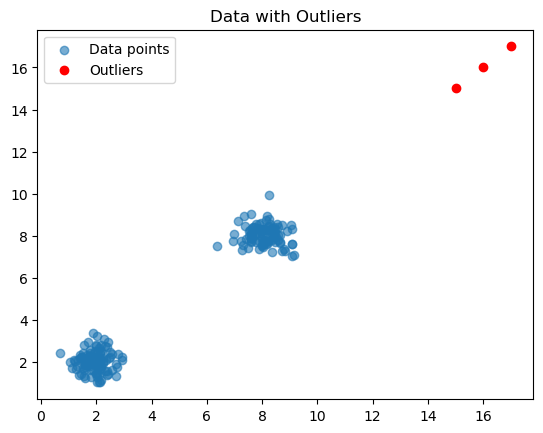

In [667]:
np.random.seed(42)
cluster_1 = np.random.normal(loc=[2, 2], scale=0.5, size=(100, 2))
cluster_2 = np.random.normal(loc=[8, 8], scale=0.5, size=(100, 2))
X = np.vstack([cluster_1, cluster_2])


outliers = np.array([[15, 15], [16, 16], [17, 17]])
xoutliers = np.vstack([X, outliers])

plt.scatter(X[:, 0], X[:, 1], label='Data points', alpha=0.6)
plt.scatter(outliers[:, 0], outliers[:, 1], color='red', label='Outliers')
plt.title('Data with Outliers')
plt.legend()
plt.show()

In [669]:
labels_l1_outliers, centroids_l1_outliers, objective_values_l1_outliers = kmeans_l1(xoutliers, k=2)
labels_euclidean_outliers, centroids_euclidean_outliers, objective_values_euclidean_outliers = kmeans(xoutliers, k=2)

In [671]:
print("Centroids from kmeans_l1 (with outliers):", centroids_l1_outliers)
print("Centroids from kmeans (with outliers):", centroids_euclidean_outliers)

Centroids from kmeans_l1 (with outliers): [[8.09952985 8.01050192]
 [1.98236555 2.06616192]]
Centroids from kmeans (with outliers): [[1.94221787 2.01701116]
 [8.29526637 8.25412022]]


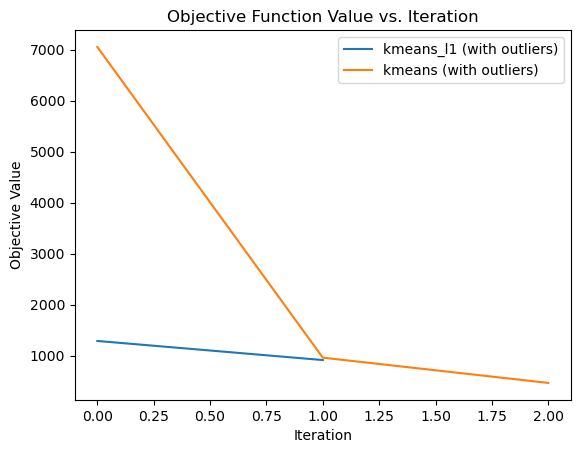

In [673]:
plt.plot(objective_values_l1_outliers, label="kmeans_l1 (with outliers)")
plt.plot(objective_values_euclidean_outliers, label="kmeans (with outliers)")
plt.title('Objective Function Value vs. Iteration')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.legend()
plt.show()

In [675]:
from sklearn.metrics import silhouette_score
silhouette_l1_outliers = silhouette_score(xoutliers, labels_l1_outliers)
print(f'Silhouette Score for kmeans_l1 (with outliers): {silhouette_l1_outliers}')
silhouette_euclidean_outliers = silhouette_score(xoutliers, labels_euclidean_outliers)
print(f'Silhouette Score for kmeans (with outliers): {silhouette_euclidean_outliers}')

Silhouette Score for kmeans_l1 (with outliers): 0.8784788857319532
Silhouette Score for kmeans (with outliers): 0.8784788857319532


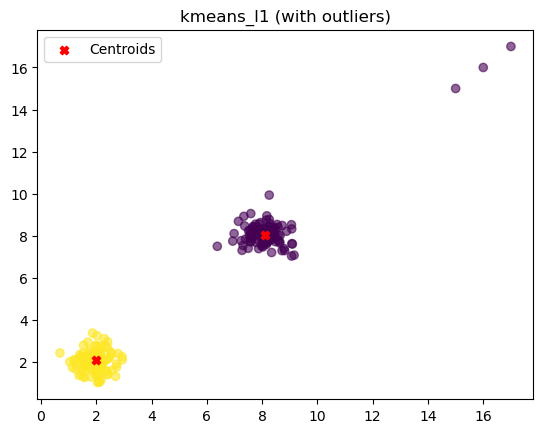

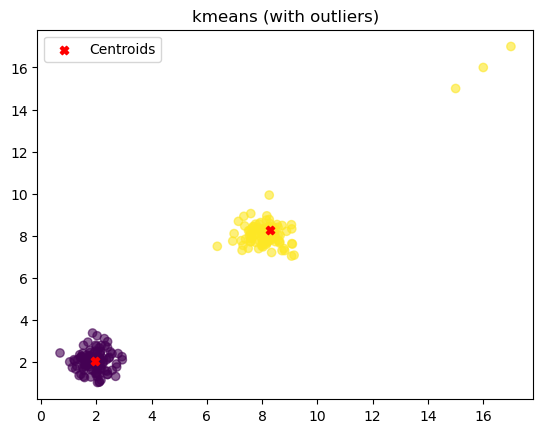

In [691]:
plt.scatter(xoutliers[:, 0], xoutliers[:, 1], c=labels_l1_outliers, cmap='viridis', alpha=0.6)
plt.scatter(centroids_l1_outliers[:, 0], centroids_l1_outliers[:, 1], color='red', marker='X', label='Centroids')
plt.title('kmeans_l1 (with outliers)')
plt.legend()
plt.show()
plt.scatter(xoutliers[:, 0], xoutliers[:, 1], c=labels_euclidean_outliers, cmap='viridis', alpha=0.6)
plt.scatter(centroids_euclidean_outliers[:, 0], centroids_euclidean_outliers[:, 1], color='red', marker='X', label='Centroids')
plt.title('kmeans (with outliers)')
plt.legend()
plt.show()


In [679]:
from sklearn.metrics import silhouette_score
silhouette_l1_outliers = silhouette_score(xoutliers, labels_l1_outliers)
print(f'Silhouette Score for kmeans_l1 (with outliers): {silhouette_l1_outliers}')

silhouette_euclidean_outliers = silhouette_score(xoutliers, labels_euclidean_outliers)
print(f'Silhouette Score for kmeans (with outliers): {silhouette_euclidean_outliers}')

Silhouette Score for kmeans_l1 (with outliers): 0.8784788857319532
Silhouette Score for kmeans (with outliers): 0.8784788857319532


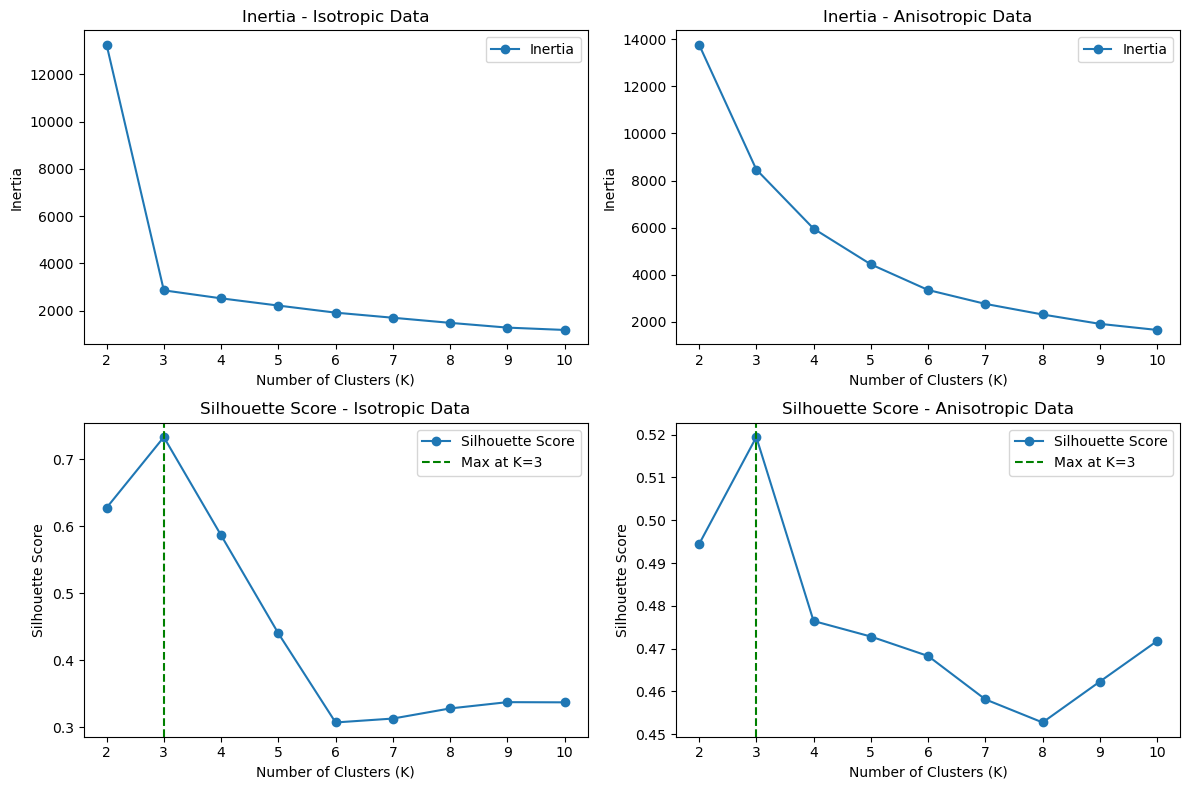

In [565]:
def evaluate_clustering(x, k_range):
    inertia = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(x)
        inertia.append(kmeans.inertia_)
        if k > 1:
            silhouette_scores.append(silhouette_score(x, labels))
        else:
            silhouette_scores.append(np.nan)
    return inertia, silhouette_scores

k_values = range(2, 11)

inertia_iso, silhouette_iso = evaluate_clustering(x, k_values)
inertia_aniso, silhouette_aniso = evaluate_clustering(xani, k_values)


optimal_k_silhouette_iso = k_values[np.argmax(silhouette_iso)]
optimal_k_silhouette_aniso = k_values[np.argmax(silhouette_aniso)]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot(k_values, inertia_iso, marker='o', label='Inertia')
axes[0, 0].set_title("Inertia - Isotropic Data")
axes[0, 0].set_xlabel("Number of Clusters (K)")
axes[0, 0].set_ylabel("Inertia")
axes[0, 0].legend()

axes[0, 1].plot(k_values, inertia_aniso, marker='o', label='Inertia')
axes[0, 1].set_title("Inertia - Anisotropic Data")
axes[0, 1].set_xlabel("Number of Clusters (K)")
axes[0, 1].set_ylabel("Inertia")
axes[0, 1].legend()

axes[1, 0].plot(k_values, silhouette_iso, marker='o', label='Silhouette Score')
axes[1, 0].axvline(optimal_k_silhouette_iso, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_iso}')
axes[1, 0].set_title("Silhouette Score - Isotropic Data")
axes[1, 0].set_xlabel("Number of Clusters (K)")
axes[1, 0].set_ylabel("Silhouette Score")
axes[1, 0].legend()

axes[1, 1].plot(k_values, silhouette_aniso, marker='o', label='Silhouette Score')
axes[1, 1].axvline(optimal_k_silhouette_aniso, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_aniso}')
axes[1, 1].set_title("Silhouette Score - Anisotropic Data")
axes[1, 1].set_xlabel("Number of Clusters (K)")
axes[1, 1].set_ylabel("Silhouette Score")
axes[1, 1].legend()

plt.tight_layout()
plt.show()



In [685]:
def whiten_data(X):
    mean=np.mean(X, axis=0)
    X_c=X - mean
    cov_matrix=np.cov(X_c, rowvar=False)
    eigvals, eigvecs=np.linalg.eigh(cov_matrix)
    X_whitened=X_c@eigvecs@np.diag(1.0/np.sqrt(eigvals))
    return X_whitened

xaniw= whiten_data(xani)

def evaluate_clustering(X, k_range):
    inertia = []
    silhouette_scores = []
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        inertia.append(kmeans.inertia_)
        if k > 1:
            silhouette_scores.append(silhouette_score(X, labels))
        else:
            silhouette_scores.append(np.nan)
    
    return inertia, silhouette_scores

k_values = range(2, 11)


inertia_iso, silhouette_iso = evaluate_clustering(x, k_values)
inertia_aniso, silhouette_aniso = evaluate_clustering(xani, k_values)
inertia_aniso_whitened, silhouette_aniso_whitened = evaluate_clustering(xaniw, k_values)


optimal_k_silhouette_iso = k_values[np.argmax(silhouette_iso)]
optimal_k_silhouette_aniso = k_values[np.argmax(silhouette_aniso)]
optimal_k_silhouette_aniso_whitened = k_values[np.argmax(silhouette_aniso_whitened)]



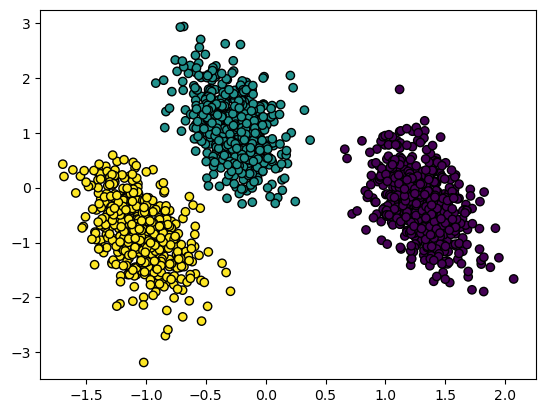

In [687]:
plt.scatter(xaniw[:, 0], xaniw[:, 1], c=y, cmap='viridis', edgecolors='k')

Text(0.5, 1.0, 'K-Means L1 (Anisotropic whitened)')

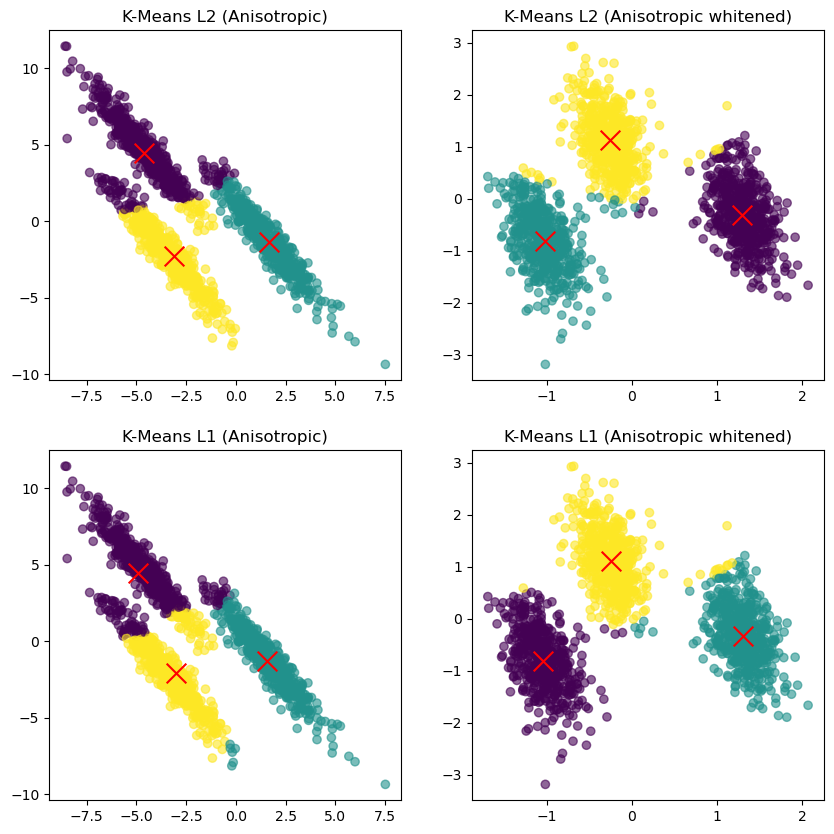

In [705]:
labels_l2_aniw, cents_l2_aniw, _ = kmeans(xaniw, k=3)

labels_l1_aniw, cents_l1_aniw,obj_vals_aniw1= kmeans_l1(xaniw, k=3)
fig, ax = plt.subplots(2,2,figsize=(10,10))

ax[0,0].scatter(xani[:, 0], xani[:, 1], c=labels_l2_ani, cmap='viridis', alpha=0.6)
ax[0,0].scatter(cents_l2_ani[:, 0], cents_l2_ani[:, 1], c='red', marker='x', s=200)
ax[0,0].set_title("K-Means L2 (Anisotropic)")

ax[0,1].scatter(xaniw[:, 0], xaniw[:, 1], c=labels_l2_aniw, cmap='viridis', alpha=0.6)
ax[0,1].scatter(cents_l2_aniw[:, 0], cents_l2_aniw[:, 1], c='red', marker='x', s=200)
ax[0,1].set_title("K-Means L2 (Anisotropic whitened)")


ax[1,0].scatter(xani[:, 0], xani[:, 1], c=labels_l1_ani, cmap='viridis', alpha=0.6)
ax[1,0].scatter(cents_l1_ani[:, 0], cents_l1_ani[:, 1], c='red', marker='x', s=200)
ax[1,0].set_title("K-Means L1 (Anisotropic)")

ax[1,1].scatter(xaniw[:, 0], xaniw[:, 1], c=labels_l1_aniw, cmap='viridis', alpha=0.6)
ax[1,1].scatter(cents_l1_aniw[:, 0], cents_l1_aniw[:, 1], c='red', marker='x', s=200)
ax[1,1].set_title("K-Means L1 (Anisotropic whitened)")



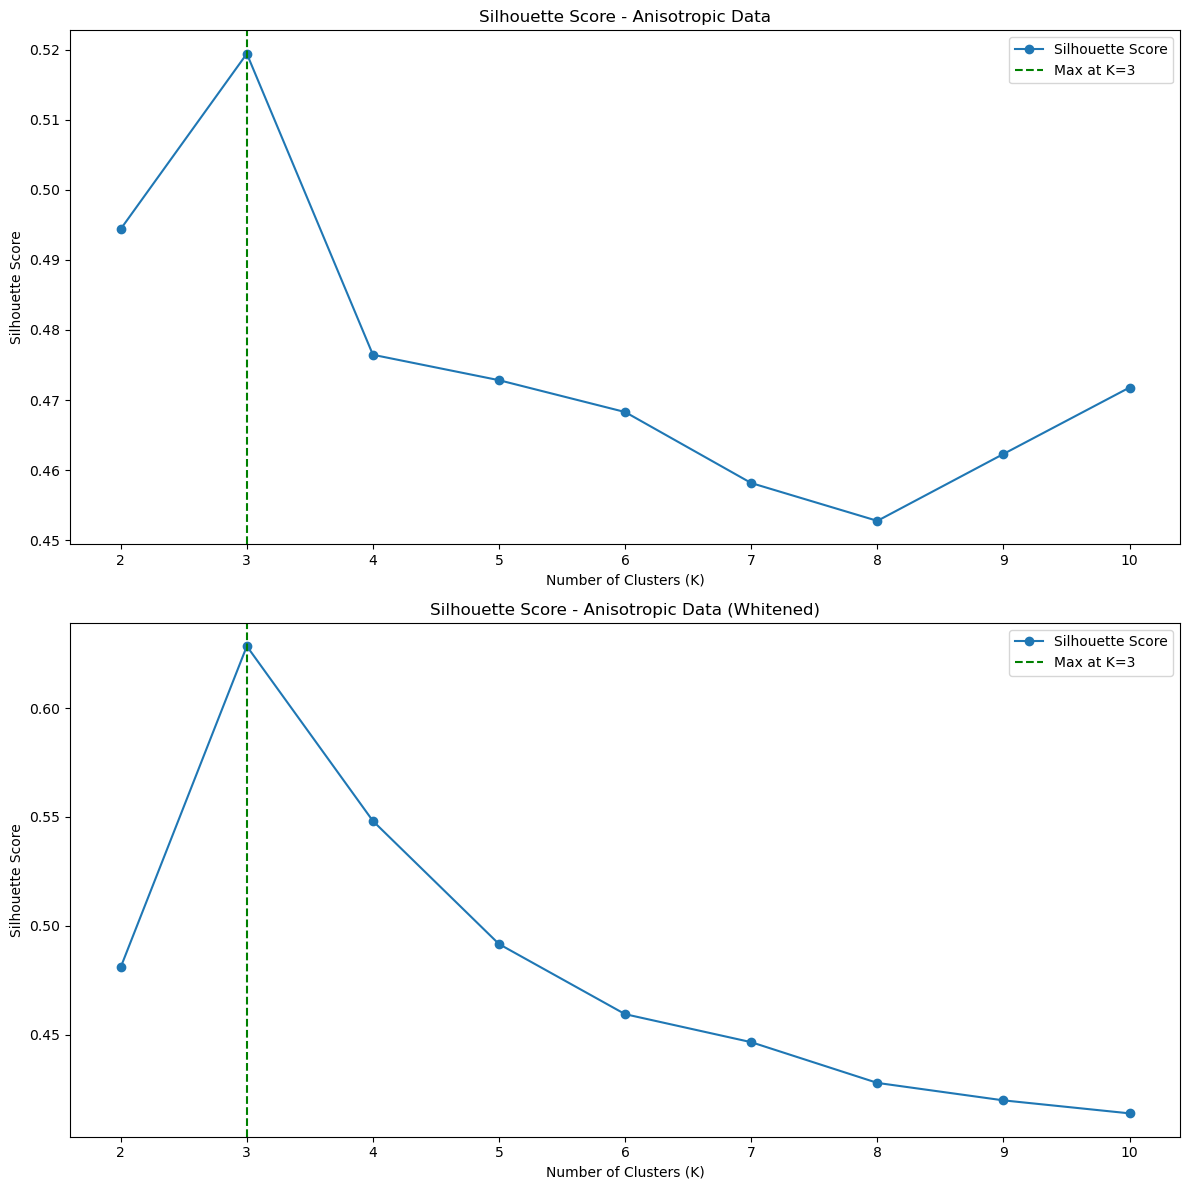

In [693]:

fig, axes = plt.subplots(2,1, figsize=(12, 12))



axes[0].plot(k_values, silhouette_aniso, marker='o', label='Silhouette Score')
axes[0].axvline(optimal_k_silhouette_aniso, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_aniso}')
axes[0].set_title("Silhouette Score - Anisotropic Data")
axes[0].set_xlabel("Number of Clusters (K)")
axes[0].set_ylabel("Silhouette Score")
axes[0].legend()

axes[1].plot(k_values, silhouette_aniso_whitened, marker='o', label='Silhouette Score')
axes[1].axvline(optimal_k_silhouette_aniso_whitened, color='g', linestyle='--', label=f'Max at K={optimal_k_silhouette_aniso_whitened}')
axes[1].set_title("Silhouette Score - Anisotropic Data (Whitened)")
axes[1].set_xlabel("Number of Clusters (K)")
axes[1].set_ylabel("Silhouette Score")
axes[1].legend()

plt.tight_layout()
plt.show()